# Introduction to natural language processing with Python

TODO: goals, overview

## Preparations

TODO: describe setup.sh etc

## Obtaining data: German news paper articles
First, we need some data. Visit https://github.com/tblock/10kgnad. It includes an `articles.csv` containing German news paper articles. Copy this file into the same folder as the notebook. The CSV is based on the [one million posts corpus](https://ofai.github.io/million-post-corpus/) which is available under the creative commons license.

Now let's read the into a Python list. Note that the actual article text is stored in the 2nd column of the CSV. 

In [1]:
import csv

with open('articles.csv', encoding='utf-8') as articles_file:
    articles_reader = csv.reader(articles_file, delimiter=';', quotechar='\'')
    articles = [row[1] for row in articles_reader]

Let's take a look at the number of articles:

In [2]:
len(articles)

10273

That should be enough data to play around with. And here's what's an actual article looks like:

In [3]:
articles[102]

'Politik-Experten in "Zeit im Bild" und "ZiB 2" – Vertrag als Analytiker. Wien – Wenn Analytiker Analytiker analysieren: Mediaaffairs verfolgt und  interpretiert gemeinhin, wie und wie ausführlich welche Politiker in welchen  Medien zu Wort kommen, etwa in der Zeit im  Bild und der ZiB 2. Nun wertete das Unternehmen die Auftritte von  Politikexperten in diesen zwei wichtigsten Nachrichtensendungen des Landes aus. Je unübersichtlicher das politische Geschehen, desto stärker die Nachfrage  nach Meinung von außen, erklärt Mediaaffairs die Auswertung. Das Ergebnis fasst  man so zusammen: Filzmaier erklärt die Welt der Politik. Rund 28 Minuten kam Peter Filzmaier (Donau-Uni Krems) im ersten Halbjahr 2015  in Zeit im Bild und ZiB 2 (ohne Sondersendungen) zu Wort. Mehr  als mancher Spitzenpolitiker, betont Mediaaffairs. Das überrascht freilich  nicht ganz: Filzmaier hat mit dem ORF einen  Vertrag als Politik-Analytiker. Der aktuelle Vertrag schließt laut Filzmaier  Aufträge von politischen Pa

## Word clouds

For starters, let's build a word cloud out of the first few articles.

First, collect the articles in a single text:

In [4]:
news_text = '\n'.join(articles[:100])

Now let's generate the word cloud and display it as an image:

In [5]:
from wordcloud import WordCloud


def color(*args, **kwargs):
    return 'black'


news_cloud = WordCloud(
    width=800, height=400,
    background_color='white', 
    color_func=color
).generate(news_text)

Now convert the word cloud to an image and render it using `mathplotlib`:

In [6]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.rcParams['figure.figsize'] = [16, 8]
plt.imshow(news_cloud, interpolation='bilinear')

Sadly this looks pretty pointless because all the words emphasized are generic German word unrelated to the actual topics the articles are about.

## Stop words

Fortunately there is a memachnism to deal with this: stop words.

Stop words are removed from processing and typically include the most common words of a language. `WordCloud` actually does have a parameter to specify such words. We could just specify a list and hope to get most of them.

However, spacy already includes such a list:

In [7]:
import spacy
nlp_de = spacy.load('de_core_news_sm')

In [8]:
stop_words_de = nlp_de.Defaults.stop_words
sorted(stop_words_de)[:20]

['a',
 'ab',
 'aber',
 'ach',
 'acht',
 'achte',
 'achten',
 'achter',
 'achtes',
 'ag',
 'alle',
 'allein',
 'allem',
 'allen',
 'aller',
 'allerdings',
 'alles',
 'allgemeinen',
 'als',
 'also']

Now let's rebuild the word cloud without stop words:

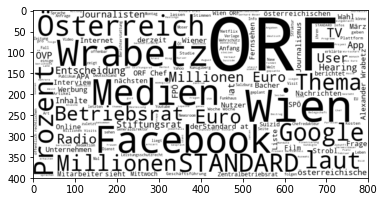

In [9]:
news_cloud_without_stop_words = WordCloud(
    width=800, height=400,
    background_color='white', 
    color_func=color,
    stopwords=stop_words_de
).generate(news_text)
plt.imshow(news_cloud_without_stop_words, interpolation='bilinear')

In comparison let's take a look at the word cloud derived from all articles:

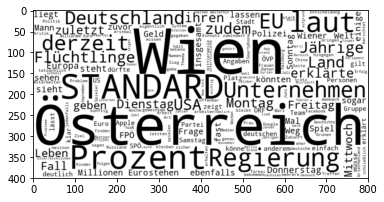

In [10]:
all_news_text = '\n'.join(articles)
news_cloud_without_stop_words = WordCloud(
    width=800, height=400,
    background_color='white', 
    color_func=color,
    stopwords=stop_words_de
).generate(all_news_text)
plt.imshow(news_cloud_without_stop_words, interpolation='bilinear')

Apparently the capital "Wien" is more important than the whole country "Österreich" ;-)

## Sents and tokens - looking at parts of an article
So far, we looked at whole articles. But what if we want to examine sentences or parts of sentences?

With spacy, you can convert a text to a document:

In [11]:
doc = nlp_de('Die blaue Rakete ist schneller als das schnellste Auto. Was wenig verwunderlich ist.')

Let's split this into sents first:

In [12]:
for sent in doc.sents:
    print(sent)

Die blaue Rakete ist schneller als das schnellste Auto.
Was wenig verwunderlich ist.


Let's examine the first sent further:

In [13]:
first_sent = next(doc.sents)
print(first_sent)

Die blaue Rakete ist schneller als das schnellste Auto.


A sent can be processed as a sequence of tokens:

In [14]:
for token in first_sent:
    print(token)

Die
blaue
Rakete
ist
schneller
als
das
schnellste
Auto
.


Let's extract a single token to further examine it:

In [15]:
special_token = list(first_sent)[4]
special_token

schneller

When simply printed, a token is rendered as a string. It actually is an object with quite a few interesting properties. For a complete list refer to https://spacy.io/api/token but here are some of the most interesting ones:

In [16]:
# The token as text
special_token.text

'schneller'

If you don't care about case there also is a lower case form available, which is faster than converting it yourself using `special_token.text.lower()`

In [17]:
special_token.lower_

'schneller'

To get rid of inflection use the lemma (or stem word):

In [18]:
# The stem word of the token
special_token.lemma_

'schnell'

There's also plenty of attributes to check if a token matches a certain form, for example `is_lower`, `is_punct`(puntuation), `like_num` (true for 10, 10.0 or ten) or `like_email`.

## Token performance

For many attributes, tokens have two representations: one as human readable text, and one as quickly processable as integer number. The typically have a similar name but the attribute with the text representation ends with an underscore (`_`):

In [19]:
special_token.lemma, special_token.lemma_

(12679834086485348841, 'schnell')

In [20]:
special_token.lower, special_token.lower_

(14987636495690372544, 'schneller')

In general, use the numeric representation for comparing tokens or storing them in a list in memory, and the text representation for printing or persistently storing in a file or database.

## Part of speech (POS) tagging
The `pos` attribute describes the role of a token in the sent, for example noun, verb, adjective. There also is a more detailed variant in `tag`.

In [21]:
for token in first_sent:
    print(f'{token.text:20} {token.pos_:10} {token.tag_:10}')

Die                  DET        ART       
blaue                ADJ        ADJA      
Rakete               NOUN       NN        
ist                  AUX        VAFIN     
schneller            ADJ        ADJD      
als                  CONJ       KOKOM     
das                  DET        ART       
schnellste           ADJ        ADJA      
Auto                 NOUN       NN        
.                    PUNCT      $.        


The various constants can be accessed or resolved using `spacy.symbols`:

In [22]:
from spacy import symbols
print(f'numeric code for ADJ is {symbols.ADJ}')
print(f'name ADJ resolves to numeric code {symbols.IDS["ADJ"]}')
print(f'name of {symbols.ADJ} is {symbols.NAMES[symbols.ADJ]}')

numeric code for ADJ is 84
name ADJ resolves to numeric code 84
name of 84 is ADJ


## Positive adjectives from customer reviews

Based on an idea described in [Using Opinion Mining and Sentiment Analysis to Discover Hidden Product Features for E-Commerce Search](https://www.slideshare.net/lucidworks/using-opinion-mining-and-sentiment-analysis-to-discover-hidden-product-features-for-ecommerce-search-suyash-sonawane-john-castillo-wayfair?qid=081f94a8-7d87-4f4b-b456-1fce9032aa3d&v=&b=&from_search=3)

Download the `7817_1.csv` from https://www.kaggle.com/sasikala11/amazon-customer-reviews and store it in the same folder as this notebook.

In [23]:
review_csv_path = '7817_1.csv'

Read reviews from the CSV:

In [24]:
import csv

asins_to_reviews_map = {}
with open(review_csv_path, encoding='utf-8') as review_csv_file:
    review_csv_reader = csv.DictReader(review_csv_file)
    for row in review_csv_reader:
        asins = row['asins']
        review = row['reviews.text']
        if asins in asins_to_reviews_map:
            asins_to_reviews_map[asins].append(review)
        else:
            asins_to_reviews_map[asins] = [review]

Now let's take the first review we come across:

In [25]:
asins = next(iter(asins_to_reviews_map.keys()))
asins

'B00QJDU3KY'

In [26]:
reviews = asins_to_reviews_map[asins]
review = reviews[0]
print(review)

I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week and I am loving my paperwhite, no regrets! The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day. (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon. Extra expense, but delivery was on time, with tracking, and I didnt need to worry about cus

Setup an nlp processor for English language:

In [27]:
import spacy
nlp_en = spacy.load('en_core_web_sm')

Split the review into sentences:

In [28]:
doc = nlp_en(review)
for sent_number, sent in enumerate(doc.sents, 1):
    print(sent_number, '-', sent)

1 - I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.
2 - Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey
3 - the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week
4 - and I am loving my paperwhite, no regrets!
5 - The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day.
6 - (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon.
7 - Extra expense, but delivery was on time, with tracking, and I 

Setup up a sentiment analyzer:

In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

Find out the sentiment for each sent:

In [30]:
sent = next(doc.sents)
print(sent)
score = analyser.polarity_scores(str(sent))
print(score)

I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.
{'neg': 0.052, 'neu': 0.876, 'pos': 0.072, 'compound': 0.1779}


Find sents that are mostly positive:

In [31]:
def mostly_positive_score_and_sents(reviews):
    for review_number, review in enumerate(reviews, 1):
        doc = nlp_en(review)
        for sent_number, sent in enumerate(doc.sents, 1):
            score = analyser.polarity_scores(str(sent))
            if score['neg'] < 0.1 and score['pos'] > 0.25:
                yield score, sent

for score, sent in mostly_positive_score_and_sents(reviews):
    print(f"{score['pos']} {sent}")

0.545 and I have to admit, I'm in love.
0.267 There was never that feeling of oh man, reading on this thing is so awesome.
0.474 That desire is back
0.474 and I simply adore my Kindle.
0.649 Make yourself happy.
0.425 Inspire the reader inside of you.
0.459 I am enjoying it so far.
0.672 Great for reading.
0.261 No Paperwhite screen, naturally, and all the cool usability that delivers, but it works well and has its own attractions as a companion to the Kindle.
0.331 Theres just so much good stuff out there!
0.275 I like having devices on which I can put anything I want and use it.
0.296 That's the one thing I'd like to see Amazon do in some future upgrades: make the Kindle treat sideloaded books just like the ones bought from them directly, with sharing funcion (quotes and Goodreads)
0.354 The size is perfect, it sits very well in the hand, the light doesn't hurt the eyes in the dark (like the light on a tab does)...
0.333 So far, I can only recommend it.
0.457 Love the form factor and

Let's extract adjectives from positive sents:

In [32]:
def positive_adjectives(reviews):
    for score, sent in mostly_positive_score_and_sents(reviews):
        for token in sent:
            if token.pos_ == 'ADJ':
                # Skip pronouns rendered as '-PRON-'
                if not token.lemma_.startswith('-'):
                    yield token.lemma_
                    
for lemma in positive_adjectives(reviews):
    print(lemma)

awesome
happy
great
cool
own
much
good
future
perfect
awesome
happy
obvious
new
worth
cool
sure
great
perfect
new
new
pleased
comfortable
positive
easy
own
quick
easy
great
nice
terrific
particulary
interesting
few
terrific
worthy
lovely
perfect
bright
original
special
great
next
good
terrific
sharp
skeptical
perfect
back
long
huge
entire
soft
white
light
free
glad
easy
little
great
perfect
quick
great
real
crisp
sharp
easy
well
original
pleased
new
dramatic
enough
great
happy
new
perfect
happy
fast
clear


In [33]:
from collections import Counter
Counter(positive_adjectives(reviews)).most_common(10)

[('great', 7),
 ('perfect', 6),
 ('new', 5),
 ('happy', 4),
 ('easy', 4),
 ('terrific', 3),
 ('awesome', 2),
 ('cool', 2),
 ('own', 2),
 ('good', 2)]

Filter too generic words:

In [34]:
GENERIC_POSITIVE_ADJECTIVES = {
    'awesome', 'good', 'great', 'happy', 'new', 'perfect', 'pleased', 'terrific',
}
Counter(
    adjective for adjective in positive_adjectives(reviews)
    if adjective not in GENERIC_POSITIVE_ADJECTIVES
).most_common(10)

[('easy', 4),
 ('cool', 2),
 ('own', 2),
 ('quick', 2),
 ('original', 2),
 ('sharp', 2),
 ('much', 1),
 ('future', 1),
 ('obvious', 1),
 ('worth', 1)]

Let's warp this in a function:

In [35]:
def most_common_positive_adjectives(reviews):
    return [
        common_adjective for common_adjective, _ in Counter(
            adjective for adjective in positive_adjectives(reviews)
            if adjective not in GENERIC_POSITIVE_ADJECTIVES
        ).most_common(10)
    ]

most_common_positive_adjectives(reviews)

['easy',
 'cool',
 'own',
 'quick',
 'original',
 'sharp',
 'much',
 'future',
 'obvious',
 'worth']

And now for a batch from of all our products (remove `islice(..., 15)` to get all of them):

In [36]:
from itertools import islice

for asins, reviews in islice(asins_to_reviews_map.items(), 15):
    print(f'{asins}: {most_common_positive_adjectives(reviews)}')

B00QJDU3KY: ['easy', 'cool', 'own', 'quick', 'original', 'sharp', 'much', 'future', 'obvious', 'worth']
B002Y27P3M: ['excellent', 'bad', 'personal', 'neat', 'cheap', 'well', 'other', 'able', 'font', 'useful']
B00DU15MU4: ['easy', 'free', 'simple', 'excellent', 'remote', 'sure']
B01LW1MS9C: ['huge', 'smart', 'fantastic', 'fit', 'nice', 'looking', 'soft', 'elegant', 'several']
B01FWSVGQQ: ['easy', 'nice', 'bright', 'vibrant', 'strong', 'first', 'well']
B00DOPNLJ0: ['available', 'downloadable', 'free', 'sound', 'excellent', 'stunning', 'excellent.---Auto', 'intuitive', 'prime', 'functional']
B00NO8LX7E: ['remote', 'huge', 'cheap', 'second', 'other', 'nice', 'laughable']
B00LWHUAF0: ['bottom', 'nice', 'well']
B00KDRQEYQ: ['fine', 'first', 'worth']
B00OQVZDJM: ['welcome', 'long', 'physical', 'incredible', 'wonderful', 'other']
B00QJDVBFU: ['welcome', 'long', 'physical', 'incredible', 'wonderful', 'other']
B00VKLBU3Y: ['sensitive', 'large', 'well', 'cheap', 'original', 'narrow', 'widescreen'

Conclusion: there is still some noise and generic words that need to be added to `GENERIC_POSITIVE_ADJECTIVES` but the general principle looks promising.

## Sentiment analysis in German
Sadly `vaderSentiment` only works with English. If you want to analyze German texts, a starting point would be [shapiro](https://github.com/roskakori/shapiro). Shapiro already knows about generic German sentiment words but for better results you need to provide a dictionary of your own. You can find more in [SentiWS](https://www.kaggle.com/rtatman/german-sentiment-analysis-toolkit), which is free for non commercial use. For more information, see R. Remus, U. Quasthoff & G. Heyer: SentiWS - a Publicly Available German-language Resource for Sentiment Analysis. In: Proceedings of the 7th International Language Ressources and Evaluation (LREC'10), 2010. There also is a spacy-plugin available: https://spacy.io/universe/project/spacy-sentiws.

## Topic classification / clustering
Sometimes you have a lot of documents that somehow probably can be grouped into similar documents, but it's not quite clear how to cluster them. This is where [gensim](https://radimrehurek.com/gensim/) can help. The following section is based on the [topics and transformations tutorial](https://radimrehurek.com/gensim/tut2.html) for gensim.

So we already have plenty of documents with our news `articles`. Let's see what kind of topics gensim can find in them.

Before we get started we need to initialize Python logging and import `gensim`:

In [37]:
import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)

from gensim import corpora, models

INFO : 'pattern' package not found; tag filters are not available for English


To start with a clean slate, read the news articles again:

In [38]:
import csv

with open('articles.csv', encoding='utf-8') as articles_file:
    articles_reader = csv.reader(articles_file, delimiter=';', quotechar='\'')
    articles = [row[1] for row in articles_reader]
articles[0]

'Die ARD-Tochter Degeto hat sich verpflichtet, ab August einer Quotenregelung zu folgen, die für die Gleichstellung von Regisseurinnen sorgen soll. In mindestens 20 Prozent der Filme, die die ARD-Tochter Degeto produziert oder mitfinanziert, sollen ab Mitte August Frauen Regie führen. Degeto-Chefin Christine Strobl folgt mit dieser Selbstverpflichtung der Forderung von Pro Quote Regie. Die Vereinigung von Regisseurinnen hatte im vergangenen Jahr eine Quotenregelung gefordert, um den weiblichen Filmschaffenden mehr Gehör und ökonomische Gleichstellung zu verschaffen. Pro Quote Regie kritisiert, dass, während rund 50 Prozent der Regie-Studierenden weiblich seien, der Anteil der Regisseurinnen bei Fernsehfilmen nur bei 13 bis 15 Prozent liege. In Österreich sieht die Situation ähnlich aus, auch hier wird von unterschiedlichen Seiten Handlungsbedarf angemahnt. Aber wie soll dieser aussehen? Ist die Einführung der Quotenregelung auch für die österreichische Film- und Fernsehlandschaft sinnv

Now we could just throw all articles at gensim. However to get better results a little cleanup is recommened. The code below will perform the following transformations:
1. Accept only actual words consisting of letters (no numbers, punctuation etc.).
1. Remove stop words.
1. Convert words to their lower case lemma.

In [39]:
cleaned_articles = []
for article in articles[:2000]:  # NOTE: slow for all articles
    doc = nlp_de(article)
    cleaned_article = [
        token.lemma_.lower() for token in doc
        if token.is_alpha and token.lower_ not in stop_words_de
    ]
    if len(cleaned_article) >= 1:
        cleaned_articles.append(cleaned_article)

Here's an example for a cleaned up article text:

In [40]:
' '.join(cleaned_articles[1])

'app annehmen planen gering nutzung schelten spiegeln online app nutzen vorstellen ausbauen'

Now we can create a gensim dictionary form these texts and store it for later processing:

In [41]:
dictionary = corpora.Dictionary(cleaned_articles)
dictionary.save('articles.dict')

INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : built Dictionary(51417 unique tokens: ['anmahnen', 'anteil', 'august', 'aussehen', 'christine']...) from 2000 documents (total 354300 corpus positions)
INFO : saving Dictionary object under articles.dict, separately None
INFO : saved articles.dict


Now we can build a corpus from that:

In [42]:
corpus = [dictionary.doc2bow(cleaned_article) for cleaned_article in cleaned_articles]
corpora.MmCorpus.serialize('article_corpus.mm', corpus)

INFO : storing corpus in Matrix Market format to article_corpus.mm
INFO : saving sparse matrix to article_corpus.mm
INFO : PROGRESS: saving document #0
INFO : PROGRESS: saving document #1000
INFO : saved 2000x51417 matrix, density=0.266% (273723/102834000)
INFO : saving MmCorpus index to article_corpus.mm.index


Now we can compute the [term frequency / inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which is a measure for each word how important it is in the context of all documents.

In [43]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

INFO : collecting document frequencies
INFO : PROGRESS: processing document #0
INFO : calculating IDF weights for 2000 documents and 51416 features (273723 matrix non-zeros)


With this information we can build a [latent semantic index (LSI)]() for our data:

In [44]:
TOPIC_COUNT = 6
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=TOPIC_COUNT)
corpus_lsi = lsi[corpus_tfidf]

INFO : using serial LSI version on this node
INFO : updating model with new documents
INFO : preparing a new chunk of documents
INFO : using 100 extra samples and 2 power iterations
INFO : 1st phase: constructing (51417, 106) action matrix
INFO : orthonormalizing (51417, 106) action matrix
INFO : 2nd phase: running dense svd on (106, 2000) matrix
INFO : computing the final decomposition
INFO : keeping 6 factors (discarding 78.400% of energy spectrum)
INFO : processed documents up to #2000
INFO : topic #0(5.146): 0.177*"prozent" + 0.146*"standard" + 0.130*"spö" + 0.124*"fpö" + 0.121*"hofer" + 0.120*"bellen" + 0.118*"van" + 0.106*"övp" + 0.103*"partei" + 0.102*"euro"
INFO : topic #1(3.237): -0.469*"bellen" + -0.457*"van" + -0.418*"hofer" + -0.152*"griss" + -0.141*"kandidat" + -0.135*"norbert" + -0.109*"lugner" + -0.106*"alexander" + -0.101*"khol" + -0.094*"hundstorfer"
INFO : topic #2(2.988): 0.516*"trump" + 0.276*"clinton" + 0.176*"republikaner" + -0.143*"häupl" + -0.142*"faymann" + -0.

Now we can print the topics gensim found based on related words in separate articles:

In [45]:
lsi.print_topics(TOPIC_COUNT)

INFO : topic #0(5.146): 0.177*"prozent" + 0.146*"standard" + 0.130*"spö" + 0.124*"fpö" + 0.121*"hofer" + 0.120*"bellen" + 0.118*"van" + 0.106*"övp" + 0.103*"partei" + 0.102*"euro"
INFO : topic #1(3.237): -0.469*"bellen" + -0.457*"van" + -0.418*"hofer" + -0.152*"griss" + -0.141*"kandidat" + -0.135*"norbert" + -0.109*"lugner" + -0.106*"alexander" + -0.101*"khol" + -0.094*"hundstorfer"
INFO : topic #2(2.988): 0.516*"trump" + 0.276*"clinton" + 0.176*"republikaner" + -0.143*"häupl" + -0.142*"faymann" + -0.141*"spö" + 0.139*"sanders" + 0.138*"cruz" + 0.114*"demokrat" + 0.110*"donald"
INFO : topic #3(2.756): 0.306*"trump" + -0.233*"orf" + 0.219*"faymann" + 0.211*"häupl" + 0.170*"spö" + 0.154*"clinton" + 0.133*"fpö" + -0.124*"euro" + 0.122*"partei" + -0.119*"million"
INFO : topic #4(2.647): -0.592*"prozent" + -0.126*"euro" + -0.109*"marktanteil" + -0.109*"million" + 0.098*"töten" + 0.090*"anschlag" + 0.082*"regierung" + 0.075*"libyen" + -0.075*"liegen" + 0.073*"standard"
INFO : topic #5(2.488)

[(0,
  '0.177*"prozent" + 0.146*"standard" + 0.130*"spö" + 0.124*"fpö" + 0.121*"hofer" + 0.120*"bellen" + 0.118*"van" + 0.106*"övp" + 0.103*"partei" + 0.102*"euro"'),
 (1,
  '-0.469*"bellen" + -0.457*"van" + -0.418*"hofer" + -0.152*"griss" + -0.141*"kandidat" + -0.135*"norbert" + -0.109*"lugner" + -0.106*"alexander" + -0.101*"khol" + -0.094*"hundstorfer"'),
 (2,
  '0.516*"trump" + 0.276*"clinton" + 0.176*"republikaner" + -0.143*"häupl" + -0.142*"faymann" + -0.141*"spö" + 0.139*"sanders" + 0.138*"cruz" + 0.114*"demokrat" + 0.110*"donald"'),
 (3,
  '0.306*"trump" + -0.233*"orf" + 0.219*"faymann" + 0.211*"häupl" + 0.170*"spö" + 0.154*"clinton" + 0.133*"fpö" + -0.124*"euro" + 0.122*"partei" + -0.119*"million"'),
 (4,
  '-0.592*"prozent" + -0.126*"euro" + -0.109*"marktanteil" + -0.109*"million" + 0.098*"töten" + 0.090*"anschlag" + 0.082*"regierung" + 0.075*"libyen" + -0.075*"liegen" + 0.073*"standard"'),
 (5,
  '-0.520*"orf" + -0.189*"puls" + -0.152*"marktanteil" + -0.144*"atv" + -0.130*"hä